In [1]:
%pip install -U langgraph langchain_community langchain_anthropic langchain_experimental

  Using cached langgraph-0.3.20-py3-none-any.whl.metadata (7.7 kB)
  Using cached langchain_community-0.3.20-py3-none-any.whl.metadata (2.4 kB)
  Using cached langchain_core-0.3.48-py3-none-any.whl.metadata (5.9 kB)
  Using cached langgraph_checkpoint-2.0.23-py3-none-any.whl.metadata (4.6 kB)
  Using cached langgraph_prebuilt-0.1.4-py3-none-any.whl.metadata (5.0 kB)
  Using cached langgraph_sdk-0.1.58-py3-none-any.whl.metadata (1.8 kB)
  Using cached langchain-0.3.21-py3-none-any.whl.metadata (7.8 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached tenacity-9.0.0-py3-none-any.whl.metadata (1.2 kB)
  Using cached dataclasses_json-0.6.7-py3-none-any.whl.metadata (25 kB)
  Using cached pydantic_settings-2.8.1-py3-none-any.whl.metadata (3.5 kB)
  Using cached langsmith-0.3.18-py3-none-any.whl.metadata (15 kB)
  Using cached httpx_sse-0.4.0-py3-none-any.whl.metadata (9.0 kB)
  Using cached pydantic-2.10.6-py3-none-any.whl.metadata (30 kB)
  Using cached aioh


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: c:\1_files\ojt\light_weight_solutions\langgraph_basics\.venv\Scripts\python.exe -m pip install --upgrade pip


In [2]:
%pip install python-dotenv langchain_groq


  Using cached langchain_groq-0.3.1-py3-none-any.whl.metadata (2.6 kB)
  Using cached groq-0.20.0-py3-none-any.whl.metadata (15 kB)
Using cached langchain_groq-0.3.1-py3-none-any.whl (15 kB)
Using cached groq-0.20.0-py3-none-any.whl (124 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: c:\1_files\ojt\light_weight_solutions\langgraph_basics\.venv\Scripts\python.exe -m pip install --upgrade pip


In [1]:

import getpass
import os
from dotenv import find_dotenv, load_dotenv
from langchain_groq import ChatGroq

dotenv_path = find_dotenv()
load_dotenv(dotenv_path)
groq_api_key = os.getenv("groq_api_key")
os.environ["groq_api_key"] = groq_api_key 

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("groq_api_key")

dotenv_path = find_dotenv()
load_dotenv(dotenv_path)
tavily_api_key = os.getenv("tavily_api_key")
os.environ["tavily_api_key"] = tavily_api_key

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("tavily_api_key")

In [2]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str

<>:23: SyntaxWarning: invalid escape sequence '\`'
<>:23: SyntaxWarning: invalid escape sequence '\`'
<>:23: SyntaxWarning: invalid escape sequence '\`'
<>:23: SyntaxWarning: invalid escape sequence '\`'
C:\Users\paulo\AppData\Local\Temp\ipykernel_10408\2391770398.py:23: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
C:\Users\paulo\AppData\Local\Temp\ipykernel_10408\2391770398.py:23: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


In [ ]:
from typing import Literal
from typing_extensions import TypedDict

from langchain_anthropic import ChatAnthropic
from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["researcher", "coder"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


#llm = ChatAnthropic(model="claude-3-5-sonnet-latest")

llm=ChatGroq(groq_api_key=groq_api_key,model_name="Llama-3.3-70b-Versatile")
class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

In [4]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent


research_agent = create_react_agent(
    llm, tools=[tavily_tool], prompt="You are a researcher. DO NOT do any math."
)


def research_node(state: State) -> Command[Literal["supervisor"]]:
    result = research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )


# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
code_agent = create_react_agent(llm, tools=[python_repl_tool])


def code_node(state: State) -> Command[Literal["supervisor"]]:
    result = code_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )


builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("coder", code_node)
graph = builder.compile()

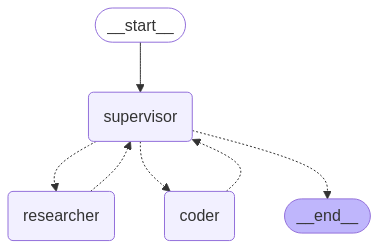

In [5]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
for s in graph.stream(
    {"messages": [("user", "What's the square root of 42?")]}, subgraphs=True
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:317191e4-c240-bfd9-960b-c798392ce44b',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_t0cv', 'function': {'arguments': '{"query":"What\'s the square root of 42?"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 94, 'prompt_tokens': 1006, 'total_tokens': 1100, 'completion_time': 0.170909091, 'prompt_time': 0.043488348, 'queue_time': 0.021019658000000004, 'total_time': 0.214397439}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e02bc748-7dad-4123-80e6-af100526d9c2-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': "What's the square root of 42?"}, 'id': 'call_t0cv', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1006, 'output_tokens': 94, 'total_tokens': 1100})]}})
----
(('researcher:317191e4-c240-

Python REPL can execute arbitrary code. Use with caution.


(('coder:7b0b55b0-e445-b168-bdbf-c5133f2a7824',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fyzp', 'function': {'arguments': '{"code":"import math; print(math.sqrt(42))"}', 'name': 'python_repl_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 93, 'prompt_tokens': 1022, 'total_tokens': 1115, 'completion_time': 0.169090909, 'prompt_time': 0.03610367, 'queue_time': 0.021328727000000006, 'total_time': 0.205194579}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5671e0f8-504a-4a44-ac27-01ac15887a63-0', tool_calls=[{'name': 'python_repl_tool', 'args': {'code': 'import math; print(math.sqrt(42))'}, 'id': 'call_fyzp', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1022, 'output_tokens': 93, 'total_tokens': 1115})]}})
----
(('coder:7b0b55b0-e445-b168-bdbf-c5133f2a7824',), {'tools': {'messages': [ToolMessage(content='Succ

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT